In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
from sklearn.manifold import TSNE
import random
from itertools import permutations
import os
import cv2

from keras.optimizers import SGD,Adam
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from keras.models import Model, Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras import backend as K

/Users/leejungjae/opt/anaconda3/envs/kr2_2_4tf1_13_1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/leejungjae/opt/anaconda3/envs/kr2_2_4tf1_13_1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/leejungjae/opt/anaconda3/envs/kr2_2_4tf1_13_1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

In [2]:
LEARNING_RATE=0.00001
MARGIN = 1.3

In [3]:
def load_data(path, row, column, channel):
    x_train=[]
    y_train=[]
    filename_train=[]
    x_test=[]
    y_test=[]
    filename_test=[]
    # Get directory
    DataPaths = [path+'/'+folder_name for folder_name in os.listdir(path)]
    print(DataPaths)
    # Check each image folders. each image folder contains images with same yoga posture 
    for label_idx in range(len(DataPaths)):
        if os.path.isdir(DataPaths[label_idx]) == False:
            continue
        LabelPath = DataPaths[label_idx]
        
        # Check each kinds of data.
        ImgPaths = [LabelPath+ '/'+image_name for image_name in os.listdir(LabelPath)]
        
        #each image
        for idx in range(len(ImgPaths)):
            imagePath = ImgPaths[idx]
            # print(imagePath)
            if ".DS_Store" in imagePath:
                continue
            img = cv2.imread(imagePath, cv2.IMREAD_COLOR)
            if channel==1:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
            img = cv2.resize(img, (row,column), interpolation = cv2.INTER_AREA)
            if idx%4==0:
                x_test.append(img)
                y_test.append(label_idx)
                filename_test.append(imagePath)
            else : 
                x_train.append(img)
                y_train.append(label_idx)
                filename_train.append(imagePath)
    return np.array(x_train), np.array(y_train), filename_train, np.array(x_test), np.array(y_test), filename_test

In [4]:
#data load
img_row=28
img_column=28
img_channel=1
path =  '../../images/data'
#사진 1장당 28*28*1 (가로*세로*채널)로 입력된다.
x_train, y_train, filename_train, x_test, y_test, filename_test = load_data(path,img_row, img_column, img_channel)
#make total data set
x_total = np.array(np.concatenate((x_train, x_test), axis = 0))
y_total = np.array(np.concatenate((y_train, y_test), axis = 0))
filename_total = np.concatenate((filename_train, filename_test), axis = 0)
y_total = np.concatenate((y_train,y_test), axis = 0)
print("before shape : ",x_train.shape, x_test.shape, x_total.shape)

['../../images/data/1865', '../../images/data/g7', '../../images/data/Barton', '../../images/data/Montes_Alpha', '../../images/data/1', '../../images/data/Diablo', '../../images/data/Canti_Brachetto', '../../images/data/3', '../../images/data/2', '../../images/data/Canti_Moscato']
before shape :  (821, 28, 28) (277, 28, 28) (1098, 28, 28)


In [5]:
def checkImgSet(msg, x_sample, y_sample, filename_sample, classes, maxnum):

    print(msg)
    for k in range(classes):
        plt.figure(figsize=(20,20))
    
        num=0
        for i in range(len(y_sample)):
            if num==maxnum:
                break
            if y_sample[i]==k:
                num+=1
                plt.subplot(10,10,num)
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                plt.imshow(x_sample[i], cmap='gray', vmin=0, vmax=255)
                #plt.imshow(cv2.cvtColor(x_sample[i], cv2.COLOR_BGR2RGB))
                plt.xlabel(str(y_sample[i])+filename_sample[i][-10:])
        plt.show()

Training Samples


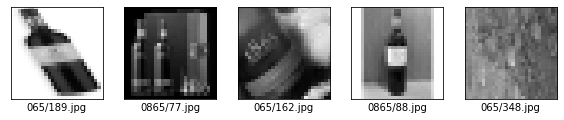

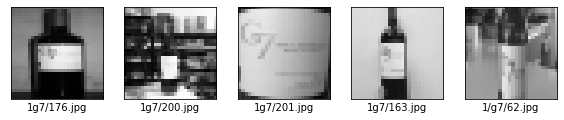

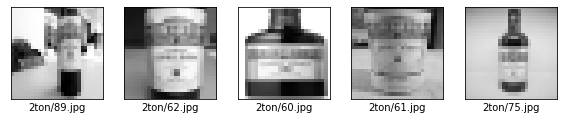

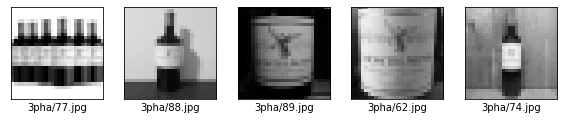

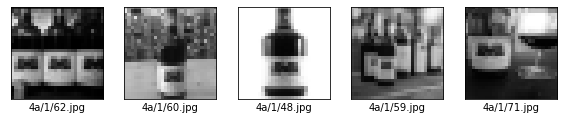

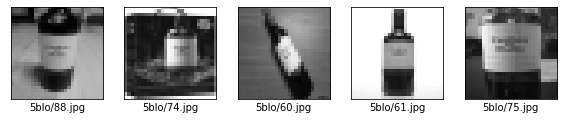

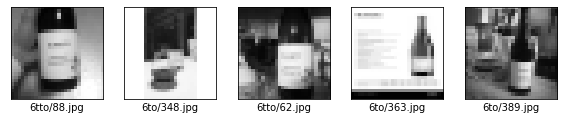

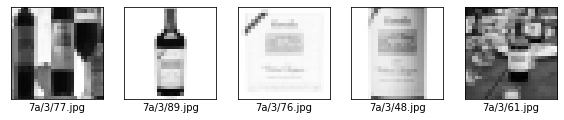

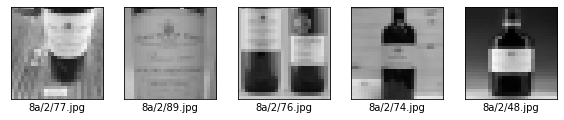

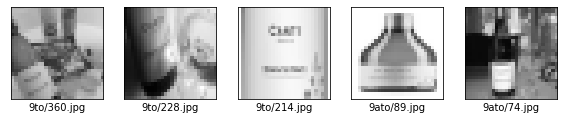

Validation Samples


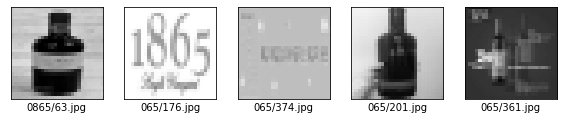

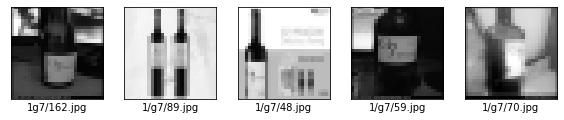

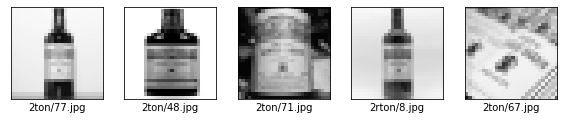

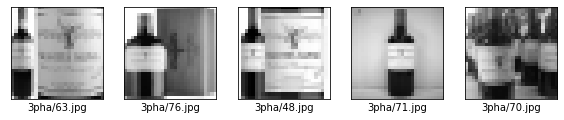

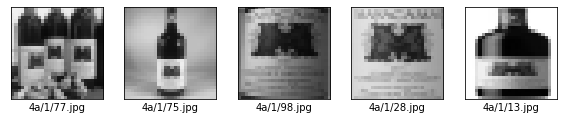

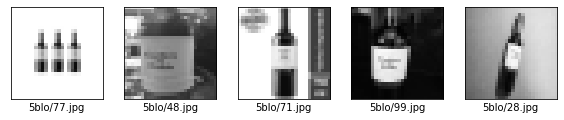

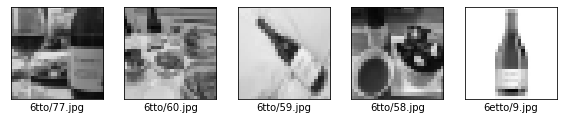

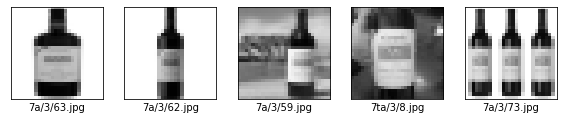

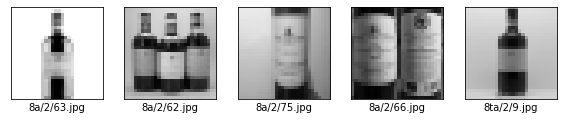

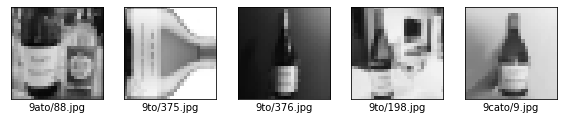

In [6]:
checkImgSet("Training Samples", x_train, y_train, filename_train, 10, 5)
checkImgSet("Validation Samples", x_test, y_test, filename_test, 10, 5)

In [7]:
print("before shape : ",x_train.shape, x_test.shape, x_total.shape)
x_train_flat = x_train.reshape(-1,img_row*img_column*img_channel)
x_test_flat = x_test.reshape(-1,img_row*img_column*img_channel)                           
x_total_flat = x_total.reshape(-1,img_row*img_column*img_channel)
print("after flat shape : ",x_train_flat.shape, x_test_flat.shape, x_total_flat.shape)

before shape :  (821, 28, 28) (277, 28, 28) (1098, 28, 28)
after flat shape :  (821, 784) (277, 784) (1098, 784)


In [8]:
# Define our own plot function
def scatter(x, labels, num_of_labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", num_of_labels))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    
    
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    # 그래프 규격선, 여백공간 제거
    ax.axis('off') 
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(num_of_labels):
        # Add Label with txt type on plotting image
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

[[-7.39877033e+00  2.09919000e+00]
 [-7.42607737e+00  1.15488081e+01]
 [-3.76768041e+00  7.59177113e+00]
 [-7.84697294e+00  2.51799774e+00]
 [ 1.17009592e+01 -1.16446714e+01]
 [ 1.02781982e+01 -3.70064330e+00]
 [-5.20524383e-01 -4.90268326e+00]
 [-4.74797392e+00  9.44954586e+00]
 [-7.46517229e+00  1.33696032e+01]
 [-1.84805810e+00 -1.04895763e+01]
 [-6.80845308e+00  9.89871502e+00]
 [-1.74340832e+00 -1.06133432e+01]
 [-1.41916018e+01  8.09249401e+00]
 [-3.13354683e+00  6.40228224e+00]
 [ 1.21021738e+01 -6.25049305e+00]
 [-7.38031292e+00  9.43179703e+00]
 [-2.58581185e+00  4.58285093e+00]
 [ 2.79578090e+00  1.84251869e+00]
 [ 1.25647945e+01 -1.27549620e+01]
 [ 1.22617283e+01 -8.65124321e+00]
 [-1.06255026e+01  1.05865364e+01]
 [ 2.99015999e-01  1.17504377e+01]
 [-3.93195033e+00  1.26662045e+01]
 [-7.99443054e+00  1.16609144e+01]
 [ 1.78826779e-01  5.41295195e+00]
 [ 8.40394592e+00 -1.10531044e+01]
 [-2.00797081e+00 -4.57207263e-01]
 [ 1.49719155e+00 -5.53341198e+00]
 [ 6.74900532e+00 -2

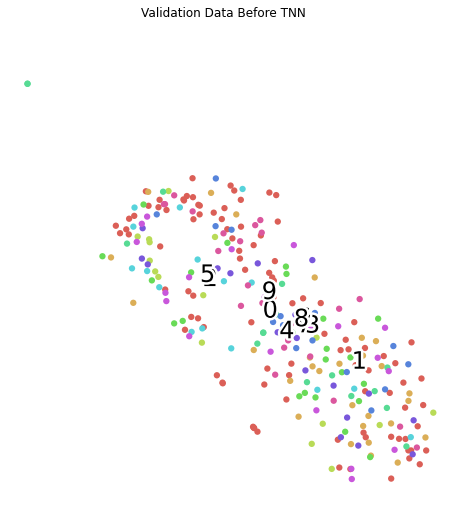

In [9]:
tsne = TSNE()
#train_tsne_embeds = tsne.fit_transform(x_train_flat[])
#scatter(train_tsne_embeds, y_train[:1641], 10, "Training Data Before TNN")

eval_tsne_embeds = tsne.fit_transform(x_test_flat)
print(eval_tsne_embeds)
scatter(eval_tsne_embeds, y_test, 10, "Validation Data Before TNN")

#total_tsne_embeds = tsne.fit_transform(x_total_flat[:1921])
#scatter(total_tsne_embeds, y_total[:1921], 10,"Total Data Before TNN")

In [10]:
def generate_triplet(x,y,ap_pairs=100,an_pairs=100, trainsize=0.7):
    data_xy = tuple([x,y])
    
    triplet_train_pairs = []
    triplet_test_pairs = []
    
    for data_class in sorted(set(data_xy[1])):
        same_class_idx = np.where(data_xy[1] == data_class)[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        print('same and diff : ', len(same_class_idx), len(diff_class_idx))
        
        ap_pairs = int((len(same_class_idx) * (len(same_class_idx)-1))/2)
        an_pairs = int(len(diff_class_idx))
        
        #print("data_class : ",data_class)
        # num of each: ap_pairs, an_pairs
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),an_pairs)
        #print(len(A_P_pairs),len(Neg_idx))
        #total data: ap_pairs*an_pairs
        A_P_len = ap_pairs
        Neg_len = an_pairs
        ng_idx=0
        print('ap' + str(len(A_P_pairs)))
        print('neg' + str(len(Neg_idx)))
        
        
        for ap in A_P_pairs[:int(A_P_len)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            Negative = data_xy[0][Neg_idx[ng_idx%Neg_len]]
            if (ng_idx%Neg_len)%4 == 0:
                triplet_test_pairs.append([Anchor,Positive,Negative])
            else: 
                triplet_train_pairs.append([Anchor,Positive,Negative])
            ng_idx+=1
                
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [11]:
print(len(y_test))

277


In [12]:

x_train_triplet, x_test_triplet = generate_triplet(x_train,y_train,1600,100)
print(x_train.shape , x_test.shape)
print(x_train_triplet.shape , x_test_triplet.shape)

same and diff :  300 521
ap44850
neg521
same and diff :  81 740
ap3240
neg740
same and diff :  44 777
ap946
neg777
same and diff :  68 753
ap2278
neg753
same and diff :  50 771
ap1225
neg771
same and diff :  45 776
ap990
neg776
same and diff :  44 777
ap946
neg777
same and diff :  56 765
ap1540
neg765
same and diff :  63 758
ap1953
neg758
same and diff :  70 751
ap2415
neg751
(821, 28, 28) (277, 28, 28)
(45211, 3, 28, 28) (15172, 3, 28, 28)


In [13]:
def create_base_network(in_dims):
    
    model = Sequential()
    model.add(Conv2D(128,(7,7),padding='same',input_shape=(in_dims[0],in_dims[1],in_dims[2],),activation='relu',name='conv1'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool1'))
    model.add(Conv2D(256,(10,10),padding='same',activation='relu',name='conv2'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool2'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(4,name='embeddings'))
    return model

In [14]:
def triplet_loss(y_true, y_pred, alpha = MARGIN):
    
    print('y_pred.shape = ',y_pred)
    
    total_lenght = y_pred.shape.as_list()[-1]
#     print('total_lenght=',  total_lenght)
#     total_lenght =12
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [15]:
#---------------------------------------------------------------------------------------------------
adam_optim = Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None)
#---------------------------------------------------------------------------------------------------
input_row=28
input_column=28
input_channel=1
anchor_input = Input((input_row, input_column, input_channel, ), name='anchor_input')
positive_input = Input((input_row, input_column, input_channel, ), name='positive_input')
negative_input = Input((input_row, input_column, input_channel, ), name='negative_input')

Shared_DNN =create_base_network([input_row, input_column, input_channel,])
encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
#---------------------------------------------------------------------------------------------------
model.compile(loss=triplet_loss, optimizer=adam_optim)
model.summary()
#---------------------------------------------------------------------------------------------------
Anchor = x_train_triplet[:,0,:].reshape(-1,input_row, input_column, input_channel)
Positive = x_train_triplet[:,1,:].reshape(-1,input_row, input_column, input_channel)
Negative = x_train_triplet[:,2,:].reshape(-1,input_row, input_column, input_channel)

Anchor_test = x_test_triplet[:,0,:].reshape(-1,input_row, input_column, input_channel)
Positive_test = x_test_triplet[:,1,:].reshape(-1,input_row, input_column, input_channel)
Negative_test = x_test_triplet[:,2,:].reshape(-1,input_row, input_column, input_channel)



Instructions for updating:
Colocations handled automatically by placer.
y_pred.shape =  Tensor("merged_layer/concat:0", shape=(?, 12), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4)            33336

In [16]:
trained_model = Model(inputs=anchor_input, outputs=encoded_anchor)
trained_model.load_weights('1.30001-0.0990-04.hdf5')


In [17]:
#x_train_flat = x_train.reshape(-1,img_row*img_column*img_channel)
#x_test_flat = x_test.reshape(-1,img_row*img_column*img_channel)                           
#x_total_flat = x_total.reshape(-1,img_row*img_column*img_channel)
#print(eval_tsne_embeds.shape)
tsne = TSNE()
X_total_trm = trained_model.predict(x_total.reshape(-1,28,28,1))
print(X_total_trm.shape)
total_tsne_embeds = tsne.fit_transform(X_total_trm)
print(total_tsne_embeds.shape)



#wine_db.append({'id':i[1], 'filename':i[2], 'vector': i[3], 'label':i[4]})


(1098, 4)
(1098, 2)


In [18]:
wine_db = []
for i in range(len(total_tsne_embeds)):
    wine_db.append({'id':i, 'filename': filename_total[i], 'vector': X_total_trm[i], 'label':y_total[i]})
#print(wine_db)

wine_db_pandas = pd.DataFrame(wine_db)
wine_db_pandas.to_csv("wine_db_dj.csv",mode = "w")
#print()

#time_pd.to_csv("filename.csv", mode='w')


In [19]:


#df = pd.DataFrame(list_data,index= )